In [1]:
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from scipy import optimize
%matplotlib inline

# Newton's method with quality constraints

First we implement an extension of Newton’s method to include equality
constraints. We will need it later for building an interior-point barrier method. The implementation follows chapter 10 of Boyd Vandenberghe Convex optimization 2004 book.

In [24]:
class NewtonMethodWithEqualityConstraints:
    def __init__(self):
        pass
    
    def _get_newton_step(self, grad_func, hessian_func, A, x):
        lhs_matrix = np.zeros(shape=(len(x) + A.shape[0], len(x) + A.shape[0]), dtype=x.dtype)
        # print('DEBUG: mat shape {}'.format(lhs_matrix.shape))

        lhs_matrix[:len(x), :len(x)] = hessian_func(x)
        lhs_matrix[len(x):, :len(x)] = A.copy()
        lhs_matrix[:len(x), len(x):] = A.T.copy()
        
        rhs_vec = np.zeros(len(x) + A.shape[0], dtype=x.dtype)
        rhs_vec[:len(x)] = -grad_func(x)
        
        # print('DEBUG: mat shape {} ; vec shape {}'.format(lhs_matrix.shape, rhs_vec.shape))
        
        solution = np.linalg.solve(lhs_matrix, rhs_vec)
        return solution[:len(x)]
    
    def _get_newton_decrement(self, hessian_func, x, newton_step):
        return np.sqrt(newton_step.T @ hessian_func(x) @ newton_step)
    
    def _backtrack_step_size(self, func, grad_func, x, step, c=0.1, tau=0.1):
        m = step.T @ grad_func(x)
        step_size = 1.
        while func(x) - func(x + step_size * step) < step_size * (-c*m):
            # print('DEBUG: x={}; x + step_size * step={}; func(x)={}; '.format(lhs_matrix.shape))
            step_size *= tau
        return step_size
        
    def minimize(self, func, grad_func, hessian_func, A, b, x0, tol=1e-6):
        report ={'xs': [x0]}
        while True:
            step = self._get_newton_step(grad_func=grad_func,
                                         hessian_func=hessian_func,
                                         A=A, x=x0)
            decrement = self._get_newton_decrement(hessian_func=hessian_func,
                                                   x=x0, newton_step=step)
            if decrement**2 / 2. < tol:
                break
            
            step_size = self._backtrack_step_size(func=func,
                                                  grad_func=grad_func,
                                                  x=x0, step=step)
            x0 = x0 + step_size * step
            report['xs'].append(x0)
        report['x0'] = x0
        return report

Let's test our implementation of Newton's method with solving a simple optimization problem defined as follows:

minimize $f(x, y) = x^2 + y^2$

subject to $x = y + 1$.

We expect to see optimal solution with $x = \frac{1}{2}$ and $y = -\frac{1}{2}$.

In [25]:
f = lambda x: np.sum(x**2)
df = lambda x: 2*x
d2f = lambda x: np.diag([2., 2.])

solver = NewtonMethodWithEqualityConstraints()

A = np.array([1., -1.]).reshape(1, 2)
b = np.array([1.])
x0 = np.array([11., 10.])

solver.minimize(func=f, grad_func=df, hessian_func=d2f, A=A, b=b, x0=x0)

{'x0': array([ 0.5, -0.5]), 'xs': [array([11., 10.]), array([ 0.5, -0.5])]}

# Interior-point barrier method
Now we are ready to implement the barrier method. The implementations follows chapter 11 of Boyd Vandenberghe Convex optimization 2004 book.

In [26]:
class BarrierSolver:
    """An implemetation of barrier method: an interior-point algorithm 
    from Boyd Vandenberghe Convex optimization 2004"""
    def __init__(self, func0, grad_func0, hessian_func0, barrier_func,
                       grad_barrier_func, hessian_barrier_func,
                       A, b, m):
        self._f0 = func0
        self._gf0 = grad_func0
        self._hf0 = hessian_func0
        
        self._bf = barrier_func
        self._gbf = grad_barrier_func
        self._hbf = hessian_barrier_func
        
        self._A = A
        self._b = b
        self._m = m
        
        self._newtons_method = NewtonMethodWithEqualityConstraints()
    
    def _get_functions(self, t):
        func = lambda x: t * self._f0(x) + self._bf(x)
        grad_func = lambda x: t * self._gf0(x) + self._gbf(x)
        hessian_func = lambda x: t * self._hf0(x) + self._hbf(x)
        return func, grad_func, hessian_func
    
    def _centering_step(self, x, t, tol):
        f, gf, hf = self._get_functions(t)
        x_centered = self._newtons_method.minimize(func=f,
                                                   grad_func=gf,
                                                   hessian_func=hf,
                                                   A=self._A,
                                                   b=self._b,
                                                   x0=x, tol=tol)
        return x_centered
    
    def minimize(self, x0, t=1., mu=10., tol=1e-6):
        report = {'xs': [x0]}
        # print('num_iter={}; x={}'.format(num_iter, x0))
        while True:
            newton_report = self._centering_step(x0, t, tol=tol)
            x0 = newton_report['x0']
            report['xs'].extend(newton_report['xs'][1:])
            # print('num_iter={}; x={}'.format(num_iter, x0))
            if self._m / t < tol:
                break
            t *= mu
            
        report['x0'] = x0
        report['min_f'] = self._f0(x0)
        
        report['fs'] = list(map(self._f0, report['xs']))
        report['num_iters'] = len(report['xs'])
        return report

Now we apply the implemented method to the problem of communication channel capacity. 

In [27]:
def func(z, c, n, m):
    """ z = (x1, ..., xn, y1, ..., ym)"""
    assert len(z) == n + m
    assert len(c) == n
    
    comp1 = np.dot(c, z[:n])
    comp2 = np.sum([y_j * np.log2(y_j) for y_j in z[-m:]])
    return comp1 + comp2

def grad_func(z, c, n, m):
    """ z = (x1, ..., xn, y1, ..., ym)"""
    assert len(z) == n + m
    assert len(c) == n

    res = np.zeros(len(z), dtype=z.dtype)
    res[:n] = c
    res[-m:] = 1. / np.log(2.) + np.log2(z[-m:])
    return res

def hessian_func(z, c, n, m):
    """ z = (x1, ..., xn, y1, ..., ym)"""
    assert len(z) == n + m
    assert len(c) == n
    
    res = np.zeros(shape=(n + m, n + m), dtype=z.dtype)
    for j in range(m):
        res[n + j, n + j] = 1. / (z[n + j] * np.log(2.))
    return res

def barrier_func(z, n, m):
    """ z = (x1, ..., xn, y1, ..., ym)"""
    assert len(z) == n + m
    
    if np.min(z[:n]) < 0:
        return np.inf
    return -np.sum([np.log(x_i) for x_i in z[:n]])

def grad_barrier_func(z, n, m):
    """ z = (x1, ..., xn, y1, ..., ym)"""
    assert len(z) == n + m
    
    res = z.copy()
    res = -1. / res
    res[-m:] = 0
    return res

def hessian_barrier_func(z, n, m):
    """ z = (x1, ..., xn, y1, ..., ym)"""
    assert len(z) == n + m
    
    res = np.zeros(shape=(n + m, n + m), dtype=z.dtype)
    for i in range(n):
        res[i, i] = 1. / z[i]**2
    return res

In [28]:
np.random.seed(228)

n = 4
m = 5
P = np.array([np.random.uniform(size=n) for x in np.zeros(m)])
P /= P.sum(axis=0)
c_t = np.array([-np.sum(x * np.log2(x)) for x in P.T])
print(P, P.shape)


A = np.zeros(shape=(1 + m, n + m), dtype=P.dtype)
A[0, :n] = 1.
A[1:, :n] = -P
A[1:, n:] = np.diag(np.ones(m, dtype=P.dtype))

b = np.zeros(m + 1, dtype=P.dtype)
b[0] = 1.


x0 = np.random.uniform(low=0, high=10, size=n)
x0 = x0 / np.sum(x0)

y0 = P @ x0

z0 = np.hstack([x0, y0])
z0

[[0.30041621 0.15293965 0.27373994 0.23441303]
 [0.31120355 0.16629472 0.25986809 0.07468655]
 [0.10129585 0.24678942 0.13397748 0.04678755]
 [0.22110249 0.17299438 0.26001888 0.61089725]
 [0.0659819  0.26098183 0.07239561 0.03321562]] (5, 4)


array([0.15650363, 0.11312269, 0.27314528, 0.4572284 , 0.24626824,
       0.17264675, 0.10175856, 0.40451544, 0.07481102])

In [29]:
solver = BarrierSolver(func0=lambda z: func(z, c_t, n, m),
                       grad_func0=lambda z: grad_func(z, c_t, n, m),
                       hessian_func0=lambda z: hessian_func(z, c_t, n, m),
                       barrier_func=lambda z: barrier_func(z, n, m),
                       grad_barrier_func=lambda z: grad_barrier_func(z, n, m),
                       hessian_barrier_func=lambda z: hessian_barrier_func(z, n, m),
                       A=A, b=b, m=n)
report = solver.minimize(z0, tol=1e-7)
report

{'fs': [-0.17178906969658625,
  -0.16975362274604633,
  -0.18169226072942601,
  -0.1817123107519576,
  -0.18177398699057212,
  -0.20498109964589117,
  -0.2036502096019701,
  -0.20357134773692875,
  -0.20987517489270768,
  -0.214465274299116,
  -0.21792851488099063,
  -0.22061738641058537,
  -0.23814161556711788,
  -0.23608238980220975,
  -0.23462529159354317,
  -0.2341270209015951,
  -0.23409022377329025,
  -0.23777237929159978,
  -0.23870828766591123,
  -0.23928251311808468,
  -0.2396872759192763,
  -0.23999121481209995,
  -0.24191610546423847,
  -0.2416752326869589,
  -0.24148602749317138,
  -0.2414183735877118,
  -0.24141268974792673,
  -0.2421957077379564,
  -0.24231998170694724,
  -0.24229789867875162,
  -0.24228809861793854,
  -0.24228688935205756,
  -0.2423755387687363,
  -0.24237663978833268,
  -0.24237659483948715,
  -0.24238558104799113,
  -0.24238559142748972,
  -0.2423864912457523,
  -0.2423864912457523,
  -0.2423864938232807,
  -0.2423865813587316,
  -0.2423865813587316,
 

t=1.0 mu=10.0 func=-0.24238661661925232
t=1.0 mu=50.0 func=-0.24238699226277483
t=1.0 mu=100.0 func=-0.24238659688350372
t=0.1 mu=10.0 func=-0.24238659070084


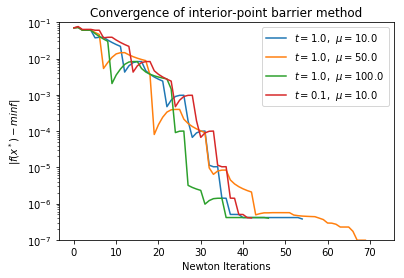

In [37]:
min_f_true = -0.24238699226277483

for t in [1., 0.1]:
    for mu in [10., 50., 100.]:
        solver = BarrierSolver(func0=lambda z: func(z, c_t, n, m),
                           grad_func0=lambda z: grad_func(z, c_t, n, m),
                           hessian_func0=lambda z: hessian_func(z, c_t, n, m),
                           barrier_func=lambda z: barrier_func(z, n, m),
                           grad_barrier_func=lambda z: grad_barrier_func(z, n, m),
                           hessian_barrier_func=lambda z: hessian_barrier_func(z, n, m),
                           A=A, b=b, m=n)
        report = solver.minimize(z0, tol=1e-7, t=t, mu=mu)

        print('t={} mu={} func={}'.format(t, mu, report['min_f']))
        plt.semilogy(np.arange(report['num_iters']), np.abs(np.array(report['fs']) - min_f_true), label=r'$t={}$,  $\mu={}$'.format(t, mu))
        
        if t == 0.1:
            break

plt.legend()
plt.xlabel('Newton Iterations')
plt.ylabel(r'$|f(x^*) - min f|$')
plt.title('Convergence of interior-point barrier method')

plt.ylim((1e-7, 1e-1))

plt.savefig('interior_point.pdf')